In [19]:
import os
os.chdir('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode')
import core
import numpy as np
import pylab as plt
import nibabel as nib
from scipy import ndimage
from skimage import filters
from scipy.ndimage.morphology import binary_erosion as be
from scipy.ndimage.morphology import binary_fill_holes as bfh
from scipy.ndimage.morphology import binary_dilation as bd
from scipy.ndimage.morphology import binary_opening as bo
from scipy.ndimage.morphology import binary_closing as bc
from scipy.ndimage.morphology import grey_dilation as gd
import time
from skimage.segmentation import find_boundaries as boundaries
import skimage
import SimpleITK as sitk
import nipype.interfaces.fsl as fsl

planes = np.load('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/planes-params.npy')
pixelspacing = []
path = '/Users/fair00542/Desktop/TestImages/ScanJ/1.2.392.200036.9116.2.6.1.48.1221600807.1432222451.975145.dcm'

path1 = '/Users/fair00542/Desktop/TestImages/ScanJ/ScanJ'

if path.endswith('.dcm'):
    array, ConstPixelSpacing, origin, path, affine = core.dicom2np(path)
    #bone = core.thresholdnp(array, 900, 1500)
    #softtissue  = core.thresholdnp(array, 0, 80)
    pixelspacing.append(ConstPixelSpacing)
    
def saveMask(array, path, name):
    mask = array.astype(np.float64)
    mask = np.swapaxes(mask, 0, 1)
    img = nib.Nifti1Image(mask, affine)
    savePath = os.path.join(os.path.split(path)[0], '{}.nii.gz'.format(name))
    nib.save(img, savePath)
 

In [2]:
#threshold, get-rid of outliars
tarray = np.multiply(array, (array>-1024).astype(int))
tarray = np.multiply(tarray, (tarray<3071).astype(int))
array1 = np.multiply(tarray, (tarray>0.0).astype(int))

#skull
skull_mask = array1>100.0 #boolea
array2 = np.multiply(array1, (array1<100.0).astype(int))

In [14]:
#smoothing image using Gaussian kernel, sigma =1mm3
import scipy
smoo = scipy.ndimage.filters.gaussian_filter(array2,sigma=1)
smoo = np.multiply(smoo,(smoo<100.0).astype(int))
smoo = np.multiply(smoo,(smoo>0.0).astype(int))
#array2(0,100), skull_mask>100

#orbital
orbital_mask = bc(skull_mask)
orbital_mask1 = bc(bc(bc(orbital_mask)))
array3 = np.multiply(smoo, (orbital_mask1==False).astype(int))

In [4]:
# plt.imshow(smoo[:,:,15])
# plt.show()

In [15]:
#bet fsl
img = nib.Nifti1Image(array3, np.eye(4))
# img = nib.Nifti1Image(array2, np.eye(4))
nib.save(img, 'temp.nii.gz')
img = nib.load('temp.nii.gz')
mybet = fsl.BET()
result = mybet.run(in_file='temp.nii.gz', out_file='BET-temp.nii.gz', frac=0.3)
img = nib.load('BET-temp.nii.gz')
data = img.get_data()
array4 = data

array5 = np.multiply(bc(bfh(bd(array4))).astype(int), array2)
array6 = bfh((array5!=0).astype(int))

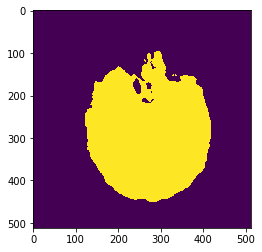

In [16]:
plt.imshow(array6[:,:,43])
plt.show()

In [8]:
# Save Brain mask
saveMask(array6,path1,'k01_01')
#use array before Gaussian Kernel to save brain array

# #After manual segmentation in ITK-SNAP
# itk = nib.load('/Users/fair00542/Desktop/DC Image Analysis/TestImages/ScanB/bb25.nii.gz')
# raw1 = itk.get_data()
# raw2 = np.swapaxes(raw1,0,1)
# raw3 = bc(bfh(raw2))
# raw4 = np.multiply(raw3,array3!=0).astype(int)

# find largest connected region
# labels = skimage.measure.label(raw4, connectivity=3)
# props = skimage.measure.regionprops(labels)
# h = [p.area for p in props]
# ind = h.index(max(h))
# hcoords = props[ind].coords
# h_loop = np.zeros((array.shape))
# for i in range(len(hcoords)):
#     a,b,c = hcoords[i]
#     h_loop[a,b,c]=1

# saveMask(h_loop,path1,'brain_edited')  ##edited brain mask, used to build the .stl brain shell.

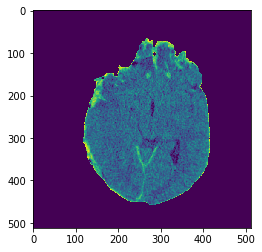

In [405]:
array5 = np.multiply(h_loop,array2).astype(int)
plt.imshow(array5[:,:,51])
plt.show()

In [406]:
array5.min()

0

# 1. ventricles

In [480]:
brain_mask = h_loop
ven_mask1 = np.multiply(brain_mask!=0, (smoo<22).astype(int))
ven_mask11 = np.multiply(brain_mask!=0, (array5<22).astype(int))
#ventricle extraction also performs better after Gaussian Kernel

In [481]:
ven_mask2 = bd(be(bd(ven_mask1)))
ven_mask3 = skimage.morphology.remove_small_objects(ven_mask2, min_size=1000, connectivity=3, in_place=False)
labels = skimage.measure.label(ven_mask3, connectivity=3)
props = skimage.measure.regionprops(labels)
v = [p.area for p in props]
ind = v.index(max(v))
vcoords = props[ind].coords
v_loop = np.zeros((array.shape))
for i in range(len(vcoords)):
    a,b,c = vcoords[i]
    v_loop[a,b,c]=1
saveMask(v_loop,path1,'ven_mask')

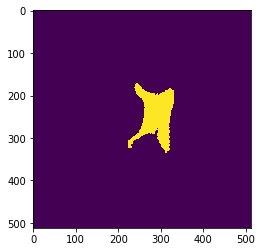

In [493]:
#ven_mask4 = np.multiply(v_loop,(array5<22)).astype(int)
plt.imshow(v_loop[:,:,70])
plt.show()
#what is it near the skull? is it csf space?

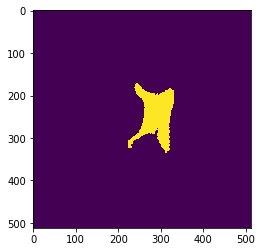

In [492]:
plt.imshow(v_loop[:,:,70])
plt.show()

# 2. Hematoma

In [501]:
hema_mask1 = np.multiply(brain_mask!=0, (smoo>50.0).astype(int))
hema_mask11 = np.multiply(brain_mask!=0, (array5>50.0).astype(int))
#ventricle extraction also performs better after Gaussian Kernel


In [522]:
hema_mask2 = bd(bfh(bc(be(hema_mask1))))
hema_mask3 = skimage.morphology.remove_small_objects(hema_mask2, min_size=500, connectivity=3, in_place=False)
#saveMask(hema_mask3,path1,'hema_mask')
#picking out the largest connected volume may get rid of some other isolated contusions

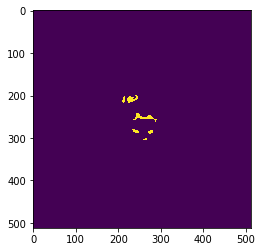

In [525]:
plt.imshow(hema_mask3[:,:,3])
plt.show()


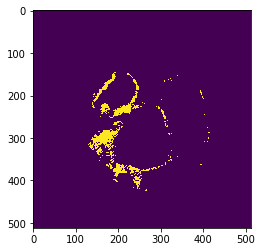

In [519]:
#hema_mask22 = bd(bfh(bc(be(hema_mask11))))
plt.imshow(hema_mask22[:,:,37])
plt.show()

# Midplane defination

In [528]:
plane = planes[0]
a,b,c,d = plane[1:].astype(np.float64)
normal = [a,b,c]

crossShape = array[:,:,0].shape
mask = np.zeros(array.shape)


In [542]:
if normal[1]>normal[0]:
    print 0
    for i in range(array.shape[2]):
        z = i
        maski = np.fromfunction(lambda x,y: y>(d-c*z-a*x)/b, crossShape)
        mask[:,:,i] = maski
        
if normal[0]>normal[1]:
    print 1
    for i in range(array.shape[2]):
        z = i
        maski = np.fromfunction(lambda x,y: x>((d-z*c-y*b)/a), crossShape)
        mask[:,:,i] = maski
        
midplane_split = np.swapaxes(mask,0,1)

1


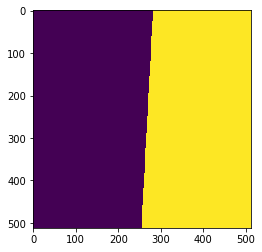

In [543]:
plt.imshow(midplane_split[:,:,2])
plt.show()

In [550]:
if normal[1]>normal[0]:
    print 0
    for i in range(array.shape[2]):
        z = i
        mask1 = np.fromfunction(lambda x,y: y>(d-c*z-a*x)/b, crossShape)
        mask1 = np.fromfunction(lambda x,y: y<(d-c*z-a*x)/b, crossShape)


        mask[:,:,i] = maski
        
if normal[0]>normal[1]:
    print 1
    for i in range(array.shape[2]):
        z = i
        mask1 = np.fromfunction(lambda x,y: x>((d-z*c-y*b)/a-2), crossShape)
        mask2 = np.fromfunction(lambda x,y: x<((d-z*c-y*b)/a+2), crossShape)
        maski = np.multiply(mask1, mask2)
        mask[:,:,i] = maski
        
##gives a midplane thickness of 2 pixels

1


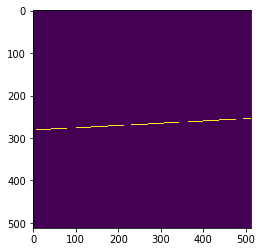

In [549]:
plt.imshow(mask[:,:,2])
plt.show()